This notebook is analysing for depth-averaged momentum budget terms in 1/8 deg OM4 simulation.

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

In [3]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:46828 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 406.01 GB


In [5]:
def global_plot(ax, da, vmin=-999, vmax=999, vstep=1,
                        lon='XC', lat='YC', landcolor=1.,
                        cmap='RdBu_r', title='what is it?'):
    """ standard global plot for the Southern Ocean """

    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
    
    # contours
    contours = np.arange(vmin, vmax+vstep, vstep)

    cf = da.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                          x=lon, y=lat,
                          levels=contours,
                          vmin=vmin, vmax=vmax,
                          add_labels=False,
                          add_colorbar=False,
                          cmap=cmap)
    # add separate colorbar
    cb = plt.colorbar(cf, ax=ax, format='%.1e', extend='both', shrink=0.9)
    cb.ax.tick_params(labelsize=12)

    ax.set_extent([-180, 180, -80, 80], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')

    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    ax.set_aspect(1.0)

    # title
    _ = plt.title(title, fontsize=16)
    return fig

In [4]:
# Read monthly-averaged files
ppdir = "/archive/Niki.Zadeh/FMS2019.01.03_devgfdl_20200921/CM4_2010Control_C_noBLING_c192_OM4p125_gridEdits_spunLand2_Rice2_tides6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/"
ds = xr.open_mfdataset(ppdir + "*.nc")

ppdir1 = "/archive/Niki.Zadeh/FMS2019.01.03_devgfdl_20200921/CM4_2010Control_C_noBLING_c192_OM4p125_gridEdits_spunLand2_Rice2_tides6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/"
ds_grid = xr.open_dataset(ppdir1 + "ocean_monthly.static.nc")

ds = ds.assign_coords({'geolon': ds_grid['geolon'], 'geolat': ds_grid['geolat'], 
                      'geolon_u': ds_grid['geolon_u'], 'geolat_u': ds_grid['geolat_u'],
                      'geolon_v': ds_grid['geolon_v'], 'geolat_v': ds_grid['geolat_v'],
                      'geolon_c': ds_grid['geolon_c'], 'geolat_c': ds_grid['geolat_c']})

print(ds)

TypeError: Error: /archive/Niki.Zadeh/FMS2019.01.03_devgfdl_20200921/CM4_2010Control_C_noBLING_c192_OM4p125_gridEdits_spunLand2_Rice2_tides6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.000101-000512.hf_CAu_2d.nc is not a valid NetCDF 3 file
            If this is a NetCDF4 file, you may need to install the
            netcdf4 library, e.g.,

            $ pip install netcdf4
            

In [21]:
# Zonal Momentum budget
idx = 100
max_r = 1.e-5

ds1 = ds.isel(time=idx)

grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
fig = plt.figure(figsize=[18,18])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.PlateCarree())
_ = global_plot(ax, ds1['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=1e-3*max_r,
                   lon='xq', lat='yh', landcolor=2., cmap='RdBu_r', title='Tendency (hf_du_dt)')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.PlateCarree())
_ = global_plot(ax, ds1['hf_CAu_2d'], vmin=-max_r, vmax=max_r, vstep=1e-1*max_r,
                   lon='xq', lat='yh', landcolor=2., cmap='RdBu_r', title='Cor. Adv. Accel. (hf_CAu)')

ax = fig.add_subplot(grid[0, 2], projection=ccrs.PlateCarree())
_ = global_plot(ax, ds1['hf_PFu_2d']+ds1['hf_u_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=1e-1*max_r,
                   lon='xq', lat='yh', landcolor=2., cmap='RdBu_r', title='Pres. Accel. (hf_PFu + hf_u_BT_accel)')
    
ax = fig.add_subplot(grid[1, 0], projection=ccrs.PlateCarree())
_ = global_plot(ax, ds1['hf_du_dt_visc_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=1e-3*max_r,
                   lon='xq', lat='yh', landcolor=2., cmap='RdBu_r', title='Stress + Fric. Accel. (hf_du_dt_visc)')

ax = fig.add_subplot(grid[1, 1], projection=ccrs.PlateCarree())
_ = global_plot(ax, ds1['hf_diffu_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=1e-3*max_r,
                   lon='xq', lat='yh', landcolor=2., cmap='RdBu_r', title='Hori. Visc. Accel. (hf_diffu)')

tmp = ds1['hf_dudt_2d']-ds1['hf_CAu_2d']-ds1['hf_PFu_2d']-ds1['hf_diffu_2d']-ds1['hf_du_dt_visc_2d']-ds1['hf_u_BT_accel_2d']
ax = fig.add_subplot(grid[1, 2], projection=ccrs.PlateCarree())
_ = global_plot(ax, tmp, vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=1e-3*max_r,
                   lon='xq', lat='yh', landcolor=2., cmap='RdBu_r', title='Residual')

distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2af9f6797ef0> (for post_execute):


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


Error in callback <function flush_figures at 0x2af9f6c51710> (for post_execute):


KeyboardInterrupt: 

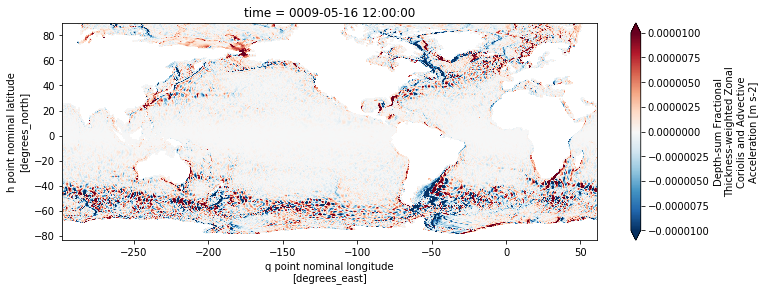

In [13]:
fig = plt.figure(figsize=[12,4])
ds1['hf_CAu_2d'].plot(vmin = -1e-5, vmax=1e-5, cmap='RdBu_r')

In [14]:
subplot_kws=dict(projection=ccrs.Robinson(),facecolor='grey')

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._subplots.AxesSubplot'>

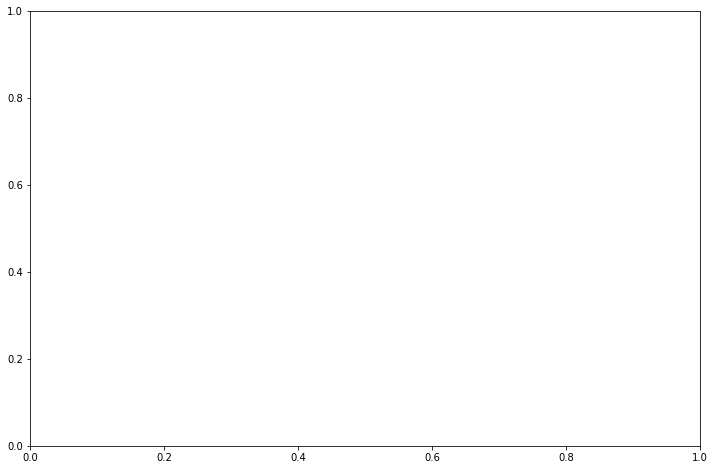

In [17]:
ds1 = ds.isel(time =100)

subplot_kws=dict(projection=ccrs.PlateCarree(),facecolor='grey')

plt.figure(figsize=[12,8])
p = ds1['hf_CAu_2d'].plot(x='geolon_u', y='geolat_u', vmin=-1e-5, vmax=1e-5, cmap='RdBu_r',
                          subplot_kws=subplot_kws, transform=ccrs.PlateCarree())
                          #add_labels=False, add_colorbar=False)

# add separate colorbar
#cb = plt.colorbar(p, shrink=0.6)
#cb.ax.tick_params(labelsize=18)

#p.axes.gridlines(color='black', alpha=0.5, linestyle='--')

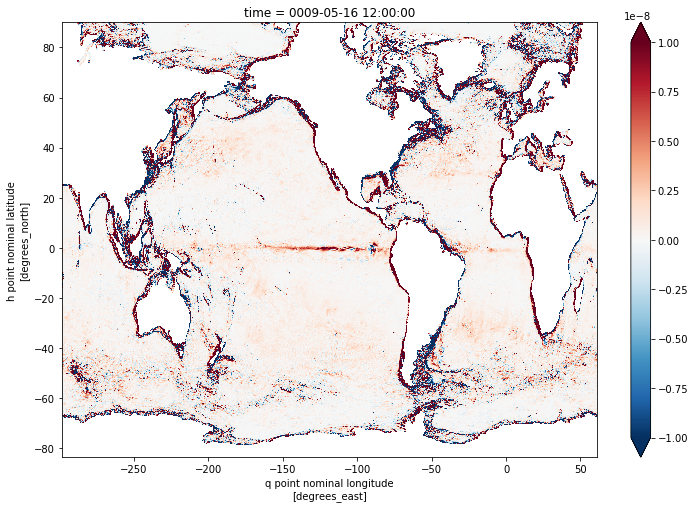

In [18]:
fig = plt.figure(figsize=[12,8])
tmp = ds1['hf_dudt_2d']-ds1['hf_CAu_2d']-ds1['hf_PFu_2d']-ds1['hf_diffu_2d']-ds1['hf_du_dt_visc_2d']-ds1['hf_u_BT_accel_2d']

#ds1['hf_dudt_2d'].plot(vmin = -1e-8, vmax=1e-8, cmap='RdBu_r')
tmp.plot(vmin = -1e-8, vmax=1e-8, cmap='RdBu_r')

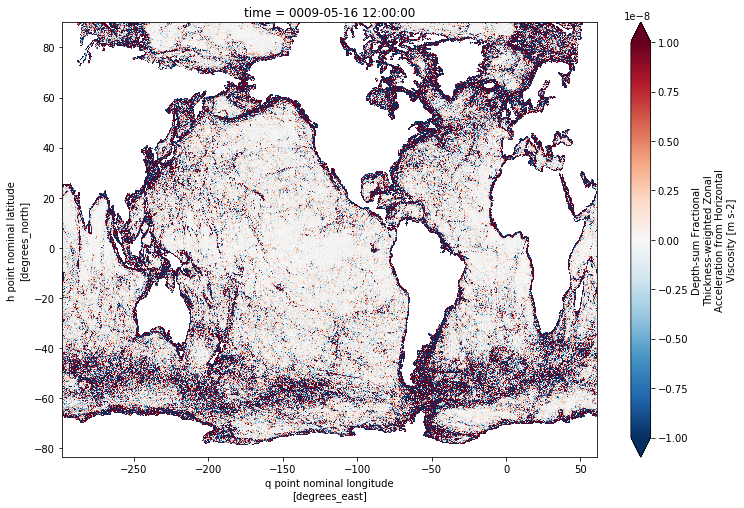

In [20]:
fig = plt.figure(figsize=[12,8])
ds1['hf_diffu_2d'].plot(vmin = -1e-8, vmax=1e-8, cmap='RdBu_r')

In [ ]:
ds.close()
client.close()
cluster.close()